<a href="https://colab.research.google.com/github/VallabhK/ExperimentsWithData/blob/master/FutureSalesPrediction1CCompany.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Future Sales Prediction**

**Problem Statement:** In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. Develop a robust model which can handle slight changes in list of shops and products.

References: https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts 

In [1]:
#importing libraries

import pandas as pd #Data processing
import numpy as np #Matrix/Linear algebraic operations
import random as rd #Random number 
import datetime #date formats

#Visualization packages
from matplotlib import pyplot as plt
import seaborn as sns

#Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

from pandas import Series

#import all the required statistics functionality
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
path_to_directory = 'https://raw.githubusercontent.com/VallabhK/ExperimentsWithData/master/Input/'

In [0]:
#importing data and converting to pandas dataframe

url = path_to_directory + 'sales_train.csv'
salestrain = pd.read_csv(url);

In [4]:
#checking imported data
salestrain.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


**File descriptions**
* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.

In [0]:
#Reading all the data files
item_categories = pd.read_csv(path_to_directory + 'item_categories.csv');
items = pd.read_csv(path_to_directory + 'items.csv');
sample_submission = pd.read_csv(path_to_directory + 'sample_submission.csv');
shops = pd.read_csv(path_to_directory + 'shops.csv');
test = pd.read_csv(path_to_directory + 'test.csv')


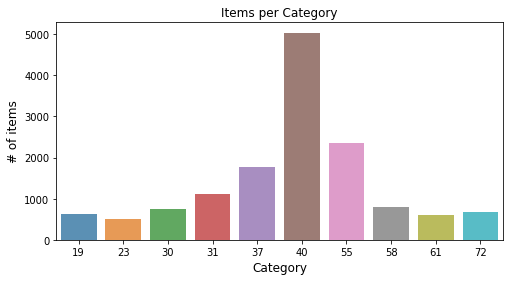

In [6]:
x=items.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

In [0]:
salestrain['date'] = pd.to_datetime(salestrain['date'], 
                                    infer_datetime_format=True)
indexedSalesDataset = salestrain.set_index(['date'])


In [0]:
#Average the monthly sales and group them by month, shop_id and item_id

SalesPerMonth = salestrain.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],
                                             "item_price":"mean",
                                             "item_cnt_day":"sum"})

In [9]:
SalesPerMonth

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-21 2013-03-01      221.0          6.0
                       33      2013-01-17 2013-03-01      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
...                                   ...        ...        ...          ...
33             59      22087   2015-05-10 2015-10-23      119.0          6.0
                       22088   2015-03-10 2015-10-27      119.0          2.0
                       22091   2015-03-10 2015-03-10      179.0          1.0
                       22100   2015-10-18 2015-10-18      629.0          1.0
                       22102   2015-10-16 2015-10-16     1250.0          1.0

[1609124 rows x 4 columns]

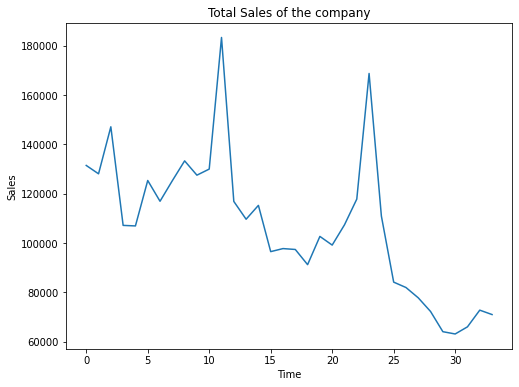

In [10]:
#Take the summation of the values for all the months for a particular item
TotalSales = salestrain.groupby(["date_block_num"])["item_cnt_day"].sum()
TotalSales.astype('float')
plt.figure(figsize=(8,6))
plt.title("Total Sales of the company")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(TotalSales);


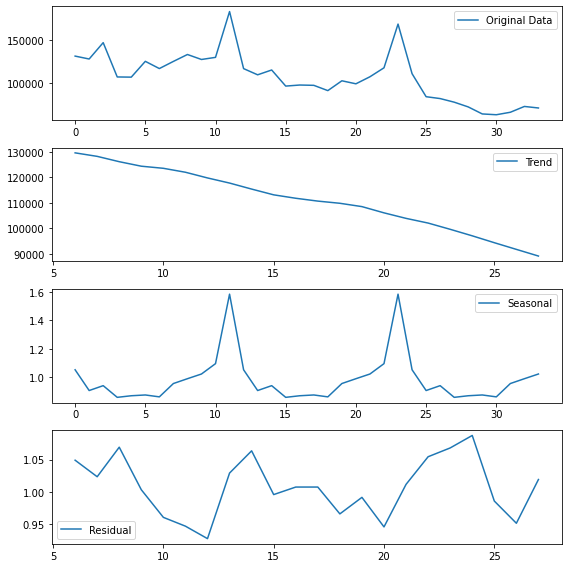

In [11]:
decomposition = seasonal_decompose(TotalSales.values, freq=12, 
                                   model="multiplicative")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(8,8))
plt.subplot(411)
plt.plot(TotalSales , label = 'Original Data')
plt.legend(loc ='best')

plt.subplot(412)
plt.plot(trend , label = 'Trend')
plt.legend(loc ='best')

plt.subplot(413)
plt.plot(seasonal , label = 'Seasonal')
plt.legend(loc ='best')

plt.subplot(414)
plt.plot(residual , label = 'Residual')
plt.legend(loc ='best')
plt.tight_layout()


In [0]:
#Check whether the data is stationary 
rollingMean = TotalSales.rolling(window=12, center = False).mean() 
#The value of window is 12 because we are computing on a monthly basis
rollingStd = TotalSales.rolling(window=12, center = False).std()
#print(rollingMean, rollingStd)

It can be observed from the data that their is seasonality in the data as the trend decreases 
after a certain time interval

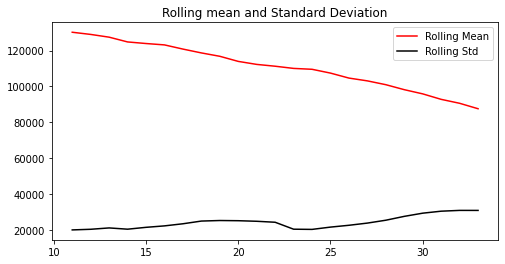

In [13]:
plt.figure(figsize=(8,4))
#originalSales = plt.plot(TotalSales , color= 'blue', label = 'Original Sales')
mean = plt.plot(rollingMean, color = 'red', label = 'Rolling Mean')
std = plt.plot(rollingStd, color = 'black', label ='Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling mean and Standard Deviation')
plt.show(block =False)

In [14]:
"""We can also check the stationarity of the data by
   using Augmented Dickey-Fuller test"""
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey Fuller test:')
dftest = adfuller(TotalSales.values, autolag ='AIC') 
# the lag function used here can be changed based on type of data

dfoutput = pd.Series(dftest[0:4], index =['Test Statistics', 'p-value', 
                                          '#Lags Used',
                                          'Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller test:
Test Statistics                -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


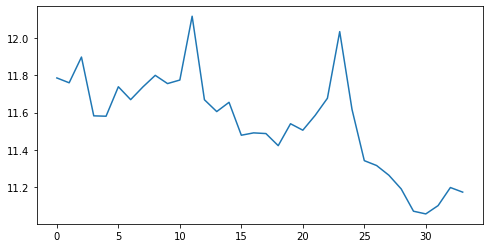

In [15]:
TotalSales_logData = np.log(TotalSales)
plt.figure(figsize=(8,4))
plt.plot(TotalSales_logData)

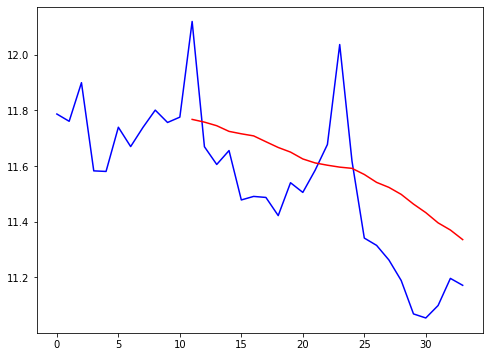

In [16]:
movingAverage = TotalSales_logData.rolling(window=12, center = False).mean() 
#The value of window is 12 because we are computing on a monthly basis
movingStd = TotalSales_logData.rolling(window=12, center = False).std()
plt.figure(figsize=(8,6))
plt.plot(TotalSales_logData, color = 'Blue')
plt.plot(movingAverage, color = 'Red')

In [17]:
logDatasetMinusMovingAverage = TotalSales_logData - movingAverage
logDatasetMinusMovingAverage.head(12)

logDatasetMinusMovingAverage.dropna(inplace= True)
logDatasetMinusMovingAverage.head(10)

date_block_num
11    0.351833
12   -0.088415
13   -0.139170
14   -0.068965
15   -0.237647
16   -0.217471
17   -0.200150
18   -0.244679
19   -0.110042
20   -0.120205
Name: item_cnt_day, dtype: float64

In [0]:
#Check the stationarity of the data for every change in dataset
from statsmodels.tsa.stattools import adfuller
def testStationarity(timeSeriesData, inputWindow):
  
  #First check the rolling mean and deviation
  rollingMean = timeSeriesData.rolling(window=inputWindow, 
                                       center = False).mean()
  rollingStd = timeSeriesData.rolling(window=inputWindow, 
                                      center = False).std()

  #Plot the rolling mean and deviation
  plt.figure(figsize=(8,4))
  """originalSales = plt.plot(timeSeriesData , color= 'blue', 
                           label = 'Original Sales')"""
  mean = plt.plot(rollingMean, color = 'red', label = 'Rolling Mean')
  std = plt.plot(rollingStd, color = 'black', label ='Rolling Std')
  plt.legend(loc = 'best')
  plt.title('Rolling mean and Standard Deviation')
  plt.show(block =False)

  #Code for Augmented Dickey Fuller Test
  print('Results of Dickey Fuller test:')
  dftest = adfuller(timeSeriesData.values, autolag ='AIC') 
  # the lag function used here can be changed based on type of data

  dfoutput = pd.Series(dftest[0:4], index =['Test Statistics', 'p-value', 
                                            '#Lags Used',
                                            'Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

  print(dfoutput)


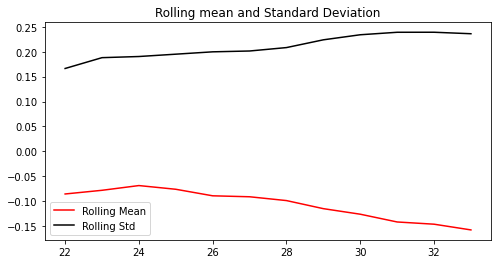

Results of Dickey Fuller test:
Test Statistics                -3.207348
p-value                         0.019563
#Lags Used                      0.000000
Number of Observations Used    22.000000
Critical Value (1%)            -3.769733
Critical Value (5%)            -3.005426
Critical Value (10%)           -2.642501
dtype: float64


In [19]:
testStationarity(logDatasetMinusMovingAverage, 12)

From the graph it can be observed that the mean and standard deviation are changing with respect to time. Hence, the next step would be to remove the trend from the data by differencing.

In [0]:
# create a differenced series
def differenceInSeries(timeSeriesData, interval=1):
	differenceInt = list()
	for i in range(interval, len(timeSeriesData)):
		value = timeSeriesData[i] - timeSeriesData[i - interval]
		differenceInt.append(value)
	return Series(differenceInt)

# invert differenced forecast
def inverse_difference(last_observation, value):
	return value + last_observation

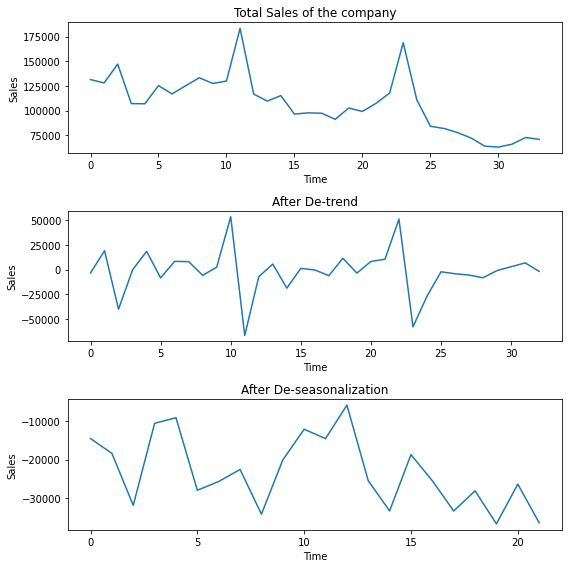

In [21]:
TotalSales = salestrain.groupby(["date_block_num"])["item_cnt_day"].sum()
TotalSales.astype('float')
plt.figure(figsize=(8,8))
plt.subplot(311)
plt.title("Total Sales of the company")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(TotalSales);

plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
differencedTotalSales = differenceInSeries(TotalSales)
plt.plot(differencedTotalSales)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
# assuming the seasonality is 12 months long
deseasonedTotalSales = differenceInSeries(TotalSales,12)       
plt.plot(deseasonedTotalSales)
plt.plot()
plt.tight_layout()

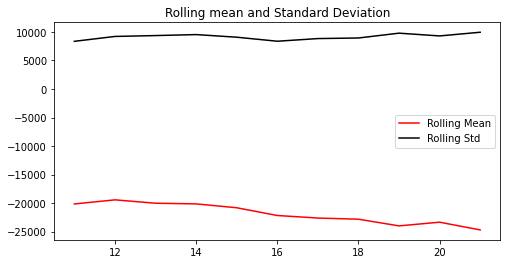

Results of Dickey Fuller test:
Test Statistics                -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [22]:
testStationarity(deseasonedTotalSales, 12)

Text(0.5, 1.0, 'Partial Autocorrelation function')

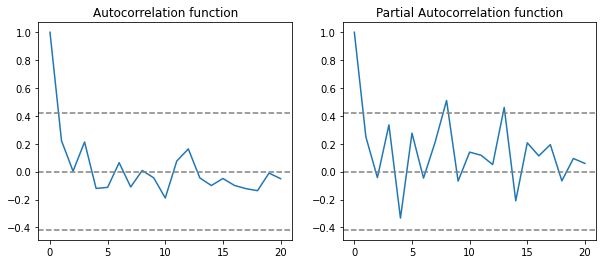

In [23]:
#Computing the Auto correlation and Partial Autocorrelation lags
lag_acf = acf(deseasonedTotalSales, nlags = 20)
lag_pacf = pacf(deseasonedTotalSales, nlags= 20, method = 'ols')

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle = '--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(deseasonedTotalSales)), linestyle = '--', color = 'gray')
plt.axhline(y=1.96/np.sqrt(len(deseasonedTotalSales)), linestyle = '--', color = 'gray')
plt.title("Autocorrelation function")

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle = '--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(deseasonedTotalSales)), linestyle = '--', color = 'gray')
plt.axhline(y=1.96/np.sqrt(len(deseasonedTotalSales)), linestyle = '--', color = 'gray')
plt.title("Partial Autocorrelation function")



In [0]:
#Documentation for certain parts to be added